<a href="https://colab.research.google.com/github/pekiouyang/DA/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 Top five records:              Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


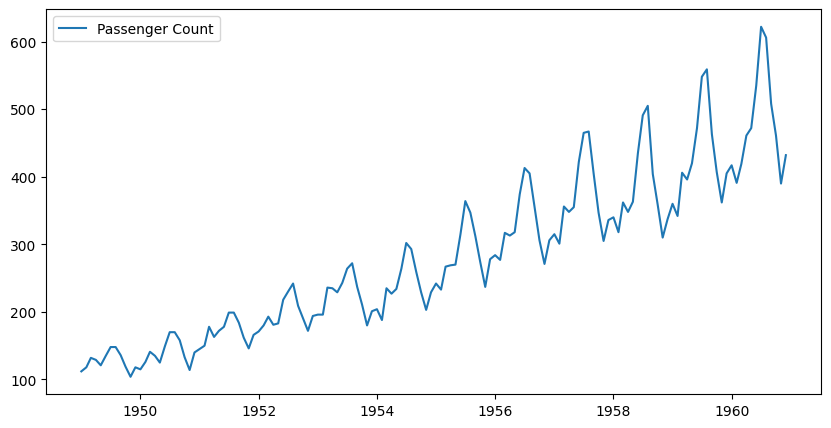

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Model: Linear Regression
MAE: 44.35
MSE: 2700.80
RMSE: 51.97
R2 Score: 0.56
----------------------------------------
Model: XGBoost
MAE: 66.15
MSE: 7729.17
RMSE: 87.92
R2 Score: -0.27
----------------------------------------
Model: ANN
MAE: 47.15
MSE: 2951.35
RMSE: 54.33
R2 Score: 0.52
----------------------------------------
Model: ARIMA
MAE: 67.33
MSE: 6499.09
RMSE: 80.62
R2 Score: -0.06
----------------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


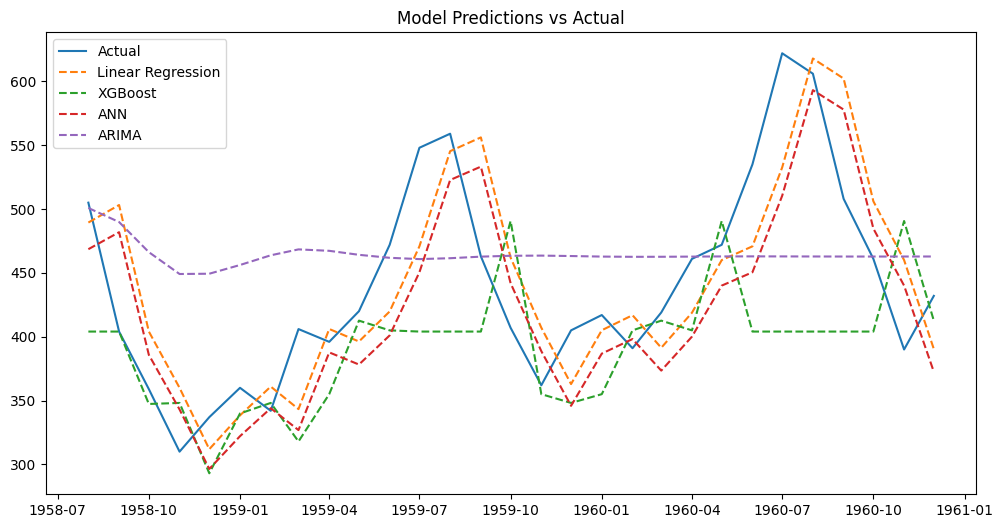

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Time Series Model
from statsmodels.tsa.arima.model import ARIMA

# Load dataset (replace with any time series data)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
print("\n Top five records: ", df.head())

# Plot data
plt.figure(figsize=(10,5))
plt.plot(df, label="Passenger Count")
plt.legend()
plt.show()

# Convert data to supervised learning format
df['Passengers_Lag1'] = df['Passengers'].shift(1)
df.dropna(inplace=True)

# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train[['Passengers_Lag1']], train['Passengers']
X_test, y_test = test[['Passengers_Lag1']], test['Passengers']

# Scale data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Passengers']])
test_scaled = scaler.transform(test[['Passengers']])

# Reshape for LSTM
X_train_lstm, y_train_lstm = train_scaled[:-1], train_scaled[1:]
X_test_lstm, y_test_lstm = test_scaled[:-1], test_scaled[1:]

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, 1))

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1,1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=0, batch_size=1)
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# ANN Model
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(32, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mse')
ann_model.fit(X_train, y_train, epochs=50, verbose=0, batch_size=1)
y_pred_ann = ann_model.predict(X_test)

# ARIMA Model
arima_model = ARIMA(train['Passengers'], order=(5,1,0))
arima_model_fit = arima_model.fit()
y_pred_arima = arima_model_fit.forecast(steps=len(test))

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R2 Score: {r2_score(y_true, y_pred):.2f}")
    print("-" * 40)

# Evaluate All Models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
# evaluate_model(y_test, y_pred_lstm.flatten(), "LSTM") # activity : Check the code for LSTM
evaluate_model(y_test, y_pred_ann.flatten(), "ANN")
evaluate_model(y_test, y_pred_arima, "ARIMA")

# Plot Predictions
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lr, label="Linear Regression", linestyle="dashed")
plt.plot(y_test.index, y_pred_xgb, label="XGBoost", linestyle="dashed")
# plt.plot(y_test.index, y_pred_lstm.flatten(), label="LSTM", linestyle="dashed")
plt.plot(y_test.index, y_pred_ann.flatten(), label="ANN", linestyle="dashed")
plt.plot(y_test.index, y_pred_arima, label="ARIMA", linestyle="dashed")
plt.legend()
plt.title("Model Predictions vs Actual")
plt.show()
